In [1]:
import io
import subprocess
import os
import glob

import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats
from sklearn.decomposition import PCA
import pickle
import re
import math
import plotnine as pn
import seaborn as sns
import glob
import subprocess
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from numpy import log
from collections import defaultdict,Counter
import re
import statsmodels
import warnings

from pathlib import Path
from midas import m
from datetime import datetime, date
import altair as alt

# !pip install statannotations==0.4.0
# #!pip uninstall statannotations --yes
# from statannotations.Annotator import Annotator

warnings.filterwarnings("ignore")
pd.options.display.max_rows = None
pd.options.display.max_columns=None
pd.options.display.max_colwidth=None
work_dir="/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/Treatement_Effect_CytomX_CSO_call_05032024"

# Data preocessing

In [2]:
# Readin samples from transfer3 batch of CytomX as this batch showed high cfDNA yield (treatment => liver damage)
df_cytomx_transfer3 = pd.read_csv(f"{work_dir}/CTM_SOW01_transfer3_10052022_tb_changed_all_cols.csv", header=1)

print("Total size of CytomX transfer3 batch is " + str(df_cytomx_transfer3.shape[0]) + "\n") 
print("Total unique sample size of CytomX transfer3 batch is " + str(df_cytomx_transfer3.GHSampleID.nunique()) + "\n")
print("Total unique patient sample size of CytomX transfer3 batch is " + str(df_cytomx_transfer3.Patient_ID.nunique()) + "\n")

# Drop duplicates 
df_cytomx_transfer3_dedup = df_cytomx_transfer3.drop_duplicates(subset=["GHSampleID"])
print("Total sample size of CytomX transfer3 batch after removing duplications is " + str(df_cytomx_transfer3_dedup.shape[0]) + "\n") 
df_cytomx_transfer3_dedup.head()

# Save the dats

Total size of CytomX transfer3 batch is 10575

Total unique sample size of CytomX transfer3 batch is 126

Total unique patient sample size of CytomX transfer3 batch is 126

Total sample size of CytomX transfer3 batch after removing duplications is 126



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Sample Type,Sample Subtype,(Nof1) Cancer Type,Cancer Stage,Tumor Type,Molecular Marker,Patient age at Sample Collection,Patient Year of Birth (YYYY),Patient Sex,Patient Pregnancy / Transplant history,Patient Treatment Information,Investigator / PI,Site Number,customersampleid,requestcreatedt,sample_received_date,cancerstage,index,index2,Description,Index Name,fc_dir,WellId,From [bp],To [bp],Average Size [bp],Conc. [ng/µl],Region Molarity [nmol/l],% of Total,Batch_ID,call,ldt_reportable,ruo_reportable,Final_RUO_call,Start,on_OMNI,variant_comment,is_deletion,molecule_count,estimated_copy_number,region_methyl_score,region_methyl_molecules,hrd_status,prob_hrd_pos,lst_score,loh_score,methyl_pred_type,sample_LR_methyl_score,methyl_score_bladder_lr,methyl_score_breast_lr,methyl_score_crc_lr,methyl_score_lung_lr,msi_score,hyper_flag,runid,chry_nonsingleton,cnv_hyper_score,contam_vscore,estimated_contam_level,hotspot_non_singleton_coverage,hotspot_umol_gc_iqr,hypo_on_target_rate,mapd,methyl_hyper_pos_highcg_count,methyl_neg_capture,methyl_pos_capture_max,methyl_pos_capture_min,sample_contamination_pct,warning
0,EPL2190,EPL2190_1001-1001_batch01,A0518803,B00143076,1001-1001,NaN,1.0,SUCCESS,NaN,SNV,NaN,ROBO2,3,77614236.0,12.0,D605G,A>G,c.1814A>G,NM_002942.5,51.56,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs200111733,NaN,NaN,NaN,NaN,1668.0,43.07,NaN,-1.365,Not Detected,0.000000,1.35,Low,Not Detected,13.195,4.2,0,NaN,NaN,10/06/2022,NaN,Not Applicable,Not Applicable,Plasma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EPL2190_1001-1001_batch01,NaN,NaN,NaN,TCCTAATAGG,CGACATCTAT,Shortened_Targeted_SEQ:Unknown:Pharma,EIO_PlateD_B1,/ghds/omni_v2/flowcells/220719_A01744_0021_AHVJHLDSX3_PROD36_AP1.Sirius-1.0.0.758-master-3e9bea4_20220808-213147,B1,100,450,206,0.203,1.59,13.76,PROD-36,1.0,0,1,1,77614235.0,Yes,NaN,NaN,NaN,NaN,NaN,NaN,HRD_Neg,0.203429,0,0,cancer_free,-3.080554,-3.080554,-5.723353,-10.914325,-7.140710,1,NaN,220719_A01744_0021_AHVJHLDSX3,0.0,0.0,0.0,0.00000,1166.0,1.618,0.83,0.04,81394.0,0.000000,1.23885,1.23885,0.02,NaN
50,EPL2190,EPL2190_1001-1004_batch01,A0518804,B00143075,1001-1004,NaN,1.0,SUCCESS,NaN,SNV,NaN,AMER1,X,63412693.0,2.0,K158K,C>T,c.474G>A,NM_152424.4,100.00,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs767248313,NaN,NaN,NaN,NaN,3241.0,0.55,NaN,-1.355,Not Detected,0.000000,4.52,Low,Not Detected,371.800,4.2,0,NaN,NaN,10/06/2022,NaN,Not Applicable,Not Applicable,Plasma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EPL2190_1001-1004_batch01,NaN,NaN,NaN,ACGTATTAAG,TGAGTACCAC,Shortened_Targeted_SEQ:Unknown:Pharma,EIO_PlateD_C1,/ghds/omni_v2/flowcells/220719_A01744_0021_AHVJHLDSX3_PROD36_AP1.Sirius-1.0.0.758-master-3e9bea4_20220808-213147,C1,100,450,223,5.720,41.70,76.00,PROD-36,1.0,0,1,1,63412692.0,Yes,NaN,NaN,NaN,NaN,NaN,NaN,HRD_Neg,0.205054,0,1,cancer_free,-4.497915,-4.497915,-5.594490,-5.251698,-5.170065,2,NaN,220719_A01744_0021_AHVJHLDSX3,0.0,0.0,2.0,0.00010,4193.0,2.753,0.82,0.12,280768.0,0.000043,1.20410,1.20410,0.02,NaN
123,EPL2190,EPL2190_1001-1005_batch01,A0518805,B00143066,1001-1005,NaN,1.0,SUCCESS,NaN,SNV,NaN,APC,5,112177960.0,16.0,S2223S,A>G,c.6669A>G,NM_000038.6,51.94,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV57375308,rs372680843,Benign/Likely_beni

# CSO Caller

## Data preprocessing

In [3]:
# Prepare the "fc_dir" columns for the data
df_cytomx_1 = df_cytomx_transfer3_dedup.copy()

# Define the path
# Path to original BIP output dir
fc_dir_all = "/ghsfa/projects/omni_v2/flowcells"
# Path to MB caller rerun by Sai which include the correct "....msre_caller_mr_features.hdr.tsv" for CSO caller
fc_dir_mb_rerun = "/ghsfa/projects/omni_v2/users/schen/methylation_data/s3-mcm-mbd-counts/mb_crc_12cpg_regular"

# Initialize new columns in the DataFrame
df_cytomx_1['fc_dir_rerun'] = ''
df_cytomx_1['fc_dir_ori'] = ''
df_cytomx_1['unique_sample_id'] = ''

# Iterate over the DataFrame rows
for index, row in df_cytomx_1.iterrows():
    runid = row["runid"]
    unique_sample_id = row["GHSampleID"] + "_" + runid
    df_cytomx_1.loc[index, 'unique_sample_id'] = unique_sample_id

    # Find rerun folder
    pattern_rerun = f"{fc_dir_mb_rerun}/*{runid}*"
    folders = glob.glob(pattern_rerun)
    df_cytomx_1.loc[index, "fc_dir_rerun"] = folders[0] if folders else ''

    # Find original folder
    pattern_ori = f"{fc_dir_all}/*{runid}*"
    folders = glob.glob(pattern_ori)
    df_cytomx_1.loc[index, "fc_dir_ori"] = folders[0] if folders else ''

    if not folders:
        print(f"No suitable folder found for {runid}")

df_cytomx_1.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Sample Type,Sample Subtype,(Nof1) Cancer Type,Cancer Stage,Tumor Type,Molecular Marker,Patient age at Sample Collection,Patient Year of Birth (YYYY),Patient Sex,Patient Pregnancy / Transplant history,Patient Treatment Information,Investigator / PI,Site Number,customersampleid,requestcreatedt,sample_received_date,cancerstage,index,index2,Description,Index Name,fc_dir,WellId,From [bp],To [bp],Average Size [bp],Conc. [ng/µl],Region Molarity [nmol/l],% of Total,Batch_ID,call,ldt_reportable,ruo_reportable,Final_RUO_call,Start,on_OMNI,variant_comment,is_deletion,molecule_count,estimated_copy_number,region_methyl_score,region_methyl_molecules,hrd_status,prob_hrd_pos,lst_score,loh_score,methyl_pred_type,sample_LR_methyl_score,methyl_score_bladder_lr,methyl_score_breast_lr,methyl_score_crc_lr,methyl_score_lung_lr,msi_score,hyper_flag,runid,chry_nonsingleton,cnv_hyper_score,contam_vscore,estimated_contam_level,hotspot_non_singleton_coverage,hotspot_umol_gc_iqr,hypo_on_target_rate,mapd,methyl_hyper_pos_highcg_count,methyl_neg_capture,methyl_pos_capture_max,methyl_pos_capture_min,sample_contamination_pct,warning,fc_dir_rerun,fc_dir_ori,unique_sample_id
0,EPL2190,EPL2190_1001-1001_batch01,A0518803,B00143076,1001-1001,NaN,1.0,SUCCESS,NaN,SNV,NaN,ROBO2,3,77614236.0,12.0,D605G,A>G,c.1814A>G,NM_002942.5,51.56,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs200111733,NaN,NaN,NaN,NaN,1668.0,43.07,NaN,-1.365,Not Detected,0.000000,1.35,Low,Not Detected,13.195,4.2,0,NaN,NaN,10/06/2022,NaN,Not Applicable,Not Applicable,Plasma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EPL2190_1001-1001_batch01,NaN,NaN,NaN,TCCTAATAGG,CGACATCTAT,Shortened_Targeted_SEQ:Unknown:Pharma,EIO_PlateD_B1,/ghds/omni_v2/flowcells/220719_A01744_0021_AHVJHLDSX3_PROD36_AP1.Sirius-1.0.0.758-master-3e9bea4_20220808-213147,B1,100,450,206,0.203,1.59,13.76,PROD-36,1.0,0,1,1,77614235.0,Yes,NaN,NaN,NaN,NaN,NaN,NaN,HRD_Neg,0.203429,0,0,cancer_free,-3.080554,-3.080554,-5.723353,-10.914325,-7.140710,1,NaN,220719_A01744_0021_AHVJHLDSX3,0.0,0.0,0.0,0.00000,1166.0,1.618,0.83,0.04,81394.0,0.000000,1.23885,1.23885,0.02,NaN,/ghsfa/projects/omni_v2/users/schen/methylation_data/s3-mcm-mbd-counts/mb_crc_12cpg_regular/220719_A01744_0021_AHVJHLDSX3_PROD36_AP1.Sirius-1.0.0-RLS_20221022-145115,/ghsfa/projects/omni_v2/flowcells/220719_A01744_0021_AHVJHLDSX3_PROD36_AP1.Sirius-1.0.0-RLS_20221022-145115,B00143076_220719_A01744_0021_AHVJHLDSX3
50,EPL2190,EPL2190_1001-1004_batch01,A0518804,B00143075,1001-1004,NaN,1.0,SUCCESS,NaN,SNV,NaN,AMER1,X,63412693.0,2.0,K158K,C>T,c.474G>A,NM_152424.4,100.00,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs767248313,NaN,NaN,NaN,NaN,3241.0,0.55,NaN,-1.355,Not Detected,0.000000,4.52,Low,Not Detected,371.800,4.2,0,NaN,NaN,10/06/2022,NaN,Not Applicable,Not Applicable,Plasma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EPL2190_1001-1004_batch01,NaN,NaN,NaN,ACGTATTAAG,TGAGTACCAC,Shortened_Targeted_SEQ:Unknown:Pharma,EIO_PlateD_C1,/ghds/omni_v2/flowcells/220719_A01744_0021_AHVJHLDSX3_PROD36_AP1.Sirius-1.0.0.758-master-3e9bea4_20220808-213147,C1,100,450,223,5.720,41.70,76.00,PROD-36,1.0,0,1,1,63412692.0,Yes,NaN,NaN,NaN,NaN,NaN,NaN,HRD_Neg,0.205054,0,1,cancer_free,-4.497915,-4.497915,-5.594490,-5.251698,-5.170065,2,NaN,220719_A01744_0021_AH

In [4]:
# Generate methylation file for CSO caller
# The wide format file was generated based on "...msre_caller_mr_features.hdr.tsv" for each GHSampleID
# Important NOTE: Keep the naming "unique_sample_id" and leave it as index name as it's suitable for CSO caller

df_methyl_merged = pd.DataFrame()

for _, row in df_cytomx_1.iterrows():
    msre_mr_file = f"{row['fc_dir_rerun']}/{row['GHSampleID']}.msre_caller_mr_features.hdr.tsv"
    df_msre_mr_file = pd.read_table(msre_mr_file)
    
    unique_sample_id = row["unique_sample_id"]
    
    # Pivot the table to wide format
    df_wide = df_msre_mr_file.pivot(index='run_sample_id', columns='region_id', values='region_score')
    
    # Set the index to unique_sample_id
    df_wide.index = [unique_sample_id]
    df_methyl_merged = pd.concat([df_methyl_merged, df_wide])

# Set the unique_sample_id as the index without resetting it
df_methyl_merged.index.name = 'unique_sample_id'
print(df_methyl_merged.shape)
df_methyl_merged.head()


(126, 2715)


region_id                                merged_0  merged_1  merged_10  \
unique_sample_id                                                         
B00143076_220719_A01744_0021_AHVJHLDSX3      -5.0 -4.207139       -5.0   
B00143075_220719_A01744_0021_AHVJHLDSX3      -5.0 -4.437284       -5.0   
B00143066_220719_A01744_0021_AHVJHLDSX3      -5.0 -4.557890       -5.0   
B00143065_220719_A01744_0021_AHVJHLDSX3      -5.0 -4.265026       -5.0   
B00143068_220719_A01744_0021_AHVJHLDSX3      -5.0 -4.173578       -5.0   

region_id                                merged_100  merged_1000  merged_1001  \
unique_sample_id                                                                
B00143076_220719_A01744_0021_AHVJHLDSX3   -5.000000         -5.0    -3.942584   
B00143075_220719_A01744_0021_AHVJHLDSX3   -4.524304         -5.0    -3.615850   
B00143066_220719_A01744_0021_AHVJHLDSX3   -4.724960         -5.0    -3.969723   
B00143065_220719_A01744_0021_AHVJHLDSX3   -4.364101         -5.0    -3.465449   
B00143068_220719_A01744_0021_AHVJHLDSX3   -5.000000         -5.0    -3.800412   

region_id                                merged_1002  merged_1003  \
unique_sample_id                                                    
B00143076_220719_A01744_0021_AHVJHLDSX3         -5.0    -5.000000   
B00143075_220719_A01744_0021_AHVJHLDSX3         -5.0    -4.633245   
B00143066_220719_A01744_0021_AHVJHLDSX3         -5.0    -5.000000   
B00143065_220719_A01744_0021_AHVJHLDSX3         -5.0    -4.676120   
B00143068_220719_A01744_0021_AHVJHLDSX3         -5.0    -4.669369   

region_id                                merged_1004  merged_1005  \
unique_sample_id                                                    
B00143076_220719_A01744_0021_AHVJHLDSX3    -4.443293         -5.0   
B00143075_220719_A01744_0021_AHVJHLDSX3    -4.633245         -5.0   
B00143066_220719_A01744_0021_AHVJHLDSX3    -5.000000         -5.0   
B00143065_220719_A01744_0021_AHVJHLDSX3    -5.000000         -5.0   
B00143068_220719_A01744_0021_AHVJHLDSX3    -4.669369         -5.0   

region_id                                merged_1006  merged_1007  \
unique_sample_id                                                    
B00143076_220719_A01744_0021_AHVJHLDSX3         -5.0         -5.0   
B00143075_220719_A01744_0021_AHVJHLDSX3         -5.0         -5.0   
B00143066_220719_A01744_0021_AHVJHLDSX3         -5.0         -5.0   
B00143065_220719_A01744_0021_AHVJHLDSX3         -5.0         -5.0   
B00143068_220719_A01744_0021_AHVJHLDSX3         -5.0         -5.0   

region_id                                merged_1008  merged_1009  merged_101  \
unique_sample_id                                                                
B00143076_220719_A01744_0021_AHVJHLDSX3         -5.0         -5.0   -5.000000   
B00143075_220719_A01744_0021_AHVJHLDSX3         -5.0         -5.0   -5.000000   
B00143066_220719_A01744_0021_AHVJHLDSX3         -5.0         -5.0   -5.000000   
B00143065_220719_A01744_0021_AHVJHLDSX3         -5.0         -5.0   -5.000000   
B00143068_220719_A01744_0021_AHVJHLDSX3         -5.0         -5.0   -4.669369   

region_id                                merged_1010  merged_1011  \
unique_sample_id                                                    
B00143076_220719_A01744_0021_AHVJHLDSX3    -4.443293    -4.055021   
B00143075_220719_A01744_0021_AHVJHLDSX3    -5.000000    -5.000000   
B00143066_220719_A01744_0021_AHVJHLDSX3    -5.000000    -5.000000   
B00143065_220719_A01744_0021_AHVJHLDSX3    -5.000000    -5.000000   
B00143068_220719_A01744_0021_AHVJHLDSX3    -5.000000    -4.105328   

region_id                                merged_1012  merged_1013  \
unique_sample_id                                                    
B00143076_220719_A01744_0021_AHVJHLDSX3         -5.0    -5.000000   
B00143075_220719_A01744_0021_AHVJHLDSX3         -5.0    -5.000000   
B00143066_220719_A01744_0021_AHVJHLDSX3         -5.0    -5.000000   
B00143065_220719_A01744_0021_AHVJHLDSX3         -5.0    -5.00000

## Load functions and model paths

In [5]:

dict_cancertype_pred = {
    "bladder":["bladder"],
    "prostate":["prostate"],
    "hepatocellular":["hepatocellular"],
    "crc":["digestive"],
    "esophageal":["digestive"],
    "pancreatic":["pancreatic"],
    "ovarian":["ovarian"],
    "lung":["lung"],
    "breast":["breast"]
}


def get_model_params(inputDir):
    modelNameFileDict = {
        '_'.join(i.name.split('_')[3::]).split('.')[0]:i for i in inputDir.glob("*.tsv")
    }
    modelNameFileDict['Pancancer'] = Path('/screening/data/locked_model_training_data/MCD/NCI_Pilot/scratch/pancancer/2024_03_19_pancancer_model.tsv')

    print(modelNameFileDict)
    model_scores_df = {}
    for eachmodel in modelNameFileDict:
        model_scores_df[eachmodel] = pd.read_table(
            modelNameFileDict.get(eachmodel),
            index_col=0
        ).rename(
            columns={"weight":"weights",
                     "coefficients":"weights"}
        )
    return model_scores_df


def get_model_score(X, mc_model_df):
    return X.dot(mc_model_df["weights"].T)  + mc_model_df.bias.iloc[0]

def apply_models(model_parameter_list, 
                df_meth):
    
    _cancerTypeModelScores = pd.DataFrame()
    for eachCancerType in model_parameter_list:
        _cancerTypeModelScores[eachCancerType] = get_model_score(
                X= df_meth, 
                mc_model_df = model_parameter_list.get(eachCancerType),
        )
    
    _cancerTypeModelScores = _cancerTypeModelScores.set_index(['Pancancer'], append=True).melt(
        var_name = "cso_model_type",
        value_name = "cso_score",
        ignore_index=False
    )

    return _cancerTypeModelScores

def get_top_model_scores(df, df_meta, top_n=1):
    this_df = df.sort_values(
        'cso_score', 
        ascending=False
        ).groupby(
            'unique_sample_id'
            ).head(n=top_n).reset_index().merge(
                df_meta,
                how = "left"
    )
    return this_df

def get_contingency(
    cancerTypeModelScores_top,
    metric_type = "sensitivity"):


    contingency_mat = pd.DataFrame(
        # index = cancerTypeNames,
        # columns = cancerTypeNames
    ) 

    for eachrow in cancerTypeModelScores_top.cso_prediction.unique().tolist():
        for eachcol in cancerTypeModelScores_top.sample_group.unique().tolist():
            sample_group_n = cancerTypeModelScores_top[cancerTypeModelScores_top.sample_group==eachcol].shape[0]
            prediction_group_n = cancerTypeModelScores_top[
                cancerTypeModelScores_top.cso_prediction==eachrow].shape[0]
            if metric_type=="sensitivity":
                contingency_mat.loc[eachrow+'(N='+str(prediction_group_n)+')',
                                    eachcol+'(N='+str(sample_group_n)+')'] = cancerTypeModelScores_top[
                                            (cancerTypeModelScores_top.sample_group == eachcol)&
                                            (cancerTypeModelScores_top.cso_prediction == eachrow)
                                            ].shape[0]/sample_group_n
                
            if metric_type=="precision":
                contingency_mat.loc[eachrow+'(N='+str(prediction_group_n)+')',
                                    eachcol+'(N='+str(sample_group_n)+')'] = cancerTypeModelScores_top[
                                            (cancerTypeModelScores_top.sample_group == eachcol)&
                                            (cancerTypeModelScores_top.cso_prediction == eachrow)
                                            ].shape[0]/prediction_group_n
            
    # print(contingency_mat.head())
    mat_plot = contingency_mat.melt(
        ignore_index=False,
        var_name = "sample_group",
        value_name = metric_type,
    ).reset_index()
    mat_plot.columns = ["CSO_prediction","sample_group", metric_type]

            
    return mat_plot

def heatmap_contingency(df, x_col, y_col, color_col, height_fig = 200, width_fig=200, col_scheme='lightgreyteal'):
    base = alt.Chart(df).encode(
        alt.X(x_col+':O', axis=alt.Axis(labelFontSize=14)),
        alt.Y(y_col+':O', axis=alt.Axis(labelFontSize=14)),
    ).properties(
        height=height_fig,
        width=width_fig
    )

    # Configure heatmap
    heatmap = base.mark_rect().encode(
        alt.Color(color_col+':Q', scale=alt.Scale(
            scheme=col_scheme, domain=(0,1)))
    )

    # Configure text
    text = base.mark_text(baseline='middle', size=16).encode(
        alt.Text(color_col+':Q', format=".2f"),
        color=alt.condition(
            alt.datum[color_col] < 0.4,
            alt.value('black'),
            alt.value('white')
        )
    )

    # Draw the chart
    return(heatmap + text)

In [6]:
modelDir = Path(
    "/screening/data/locked_model_training_data/MCD/NCI_Pilot/scratch/cso/"
)

v6_region_fn = Path(
    "/screening/notebooks/pparsana/pparsana_until_2023/screening/analysis/2023_02_14_data_for_Darya_PP/data/v6_region_annotations_from_Liyang.tsv"
)

s3_pancancer_thresh = -20.439347452871473

possible_cso_calls = ['breast', 'prostate', 'esophageal', 'ovarian', 'lung', 'bladder',
       'pancreatic', 'hepatocellular', 'crc']


## Read all CSO related data

In [7]:
# Read region metadata
v6_regions_df = pd.read_table(v6_region_fn, index_col=0).query(" chrom!='X'")
print(v6_regions_df.shape)
v6_regions_df.head()

(2715, 12)


,chrom,start,end,C_count,G_count,A_count,T_count,CG_count,region_id,merged_region_id,merged_region_type,used_in_classification
0,1,955884,956186,104,124,38,36,33,merged_0,v5_hypo_control_chr1_955885_956186,V5_HYPO_CONTROL,no
1,1,1107305,1107455,54,48,31,17,13,merged_1,myeloid_dmr_482,V6_IMMUNE_DMR,yes
2,1,2461184,2461934,241,308,100,101,98,merged_2,HES5_TSS_minus_downreg,V6_DE_TSS,yes
3,1,2984786,2985170,116,184,40,44,54,merged_3,v5_crc_dmr_chr1_2984787_2985170,V5_CRC_DMR,yes
4,1,3663703,3664004,109,120,43,29,34,merged_4,v5_tissue_dmr_chr1_3663704_3664004,V5_COLON_TISSUE_DMR,yes


In [8]:
# Read Model files
model_params_dict = get_model_params(inputDir=modelDir)

{'CSO_hepatocellular': PosixPath('/screening/data/locked_model_training_data/MCD/NCI_Pilot/scratch/cso/2024_03_19_CSO_hepatocellular.tsv'), 'CSO_breast': PosixPath('/screening/data/locked_model_training_data/MCD/NCI_Pilot/scratch/cso/2024_03_19_CSO_breast.tsv'), 'CSO_prostate': PosixPath('/screening/data/locked_model_training_data/MCD/NCI_Pilot/scratch/cso/2024_03_19_CSO_prostate.tsv'), 'CSO_pancreatic': PosixPath('/screening/data/locked_model_training_data/MCD/NCI_Pilot/scratch/cso/2024_03_19_CSO_pancreatic.tsv'), 'CSO_ovarian': PosixPath('/screening/data/locked_model_training_data/MCD/NCI_Pilot/scratch/cso/2024_03_19_CSO_ovarian.tsv'), 'CSO_crc': PosixPath('/screening/data/locked_model_training_data/MCD/NCI_Pilot/scratch/cso/2024_03_19_CSO_crc.tsv'), 'CSO_bladder': PosixPath('/screening/data/locked_model_training_data/MCD/NCI_Pilot/scratch/cso/2024_03_19_CSO_bladder.tsv'), 'CSO_esophageal': PosixPath('/screening/data/locked_model_training_data/MCD/NCI_Pilot/scratch/cso/2024_03_19_CSO

## Run CSO callers

In [9]:
# Generate CSO scores 
# Load the methylation data "df_methyl_merged"
cancerTypeModelScores = apply_models(model_parameter_list = model_params_dict, df_meth=df_methyl_merged).reset_index()
print(cancerTypeModelScores.shape)
cancerTypeModelScores.head()

(1134, 4)


,unique_sample_id,Pancancer,cso_model_type,cso_score
0,B00143076_220719_A01744_0021_AHVJHLDSX3,-21.980164,CSO_hepatocellular,-21.509317
1,B00143075_220719_A01744_0021_AHVJHLDSX3,-22.718050,CSO_hepatocellular,-22.609201
2,B00143066_220719_A01744_0021_AHVJHLDSX3,-22.796263,CSO_hepatocellular,-23.157120
3,B00143065_220719_A01744_0021_AHVJHLDSX3,-22.058002,CSO_hepatocellular,-22.205596
4,B00143068_220719_A01744_0021_AHVJHLDSX3,-15.822713,CSO_hepatocellular,-23.608305


In [10]:
# Optional step
# Merge transfer3 ad-hoc meta data from /ghds/projects/pharma/customers/CytomxTherapeutics/Infinity/CTM_SOW01_Infinity/10042022_CTM_SOW01_500samples/transfer_3
df_cytomx_adhoc_meta = pd.read_table(f"{work_dir}/genomic_samples.tsv")
# Merge the cancer type and subtype information
df_cytomx_1 = df_cytomx_1.merge(df_cytomx_adhoc_meta[['GHRequestID', 'CancerType', "Subtype"]],
                                on='GHRequestID', how='left')
# Check missing values in Cancer type
print("Total samples with missing cancer type is " + str(df_cytomx_1.CancerType.isnull().sum()) + "\n") 

# Fill missing with "OTHERS"
df_cytomx_1['CancerType'].fillna('OTHERS', inplace=True)
df_cytomx_1.head()

Total samples with missing cancer type is 2



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Sample Type,Sample Subtype,(Nof1) Cancer Type,Cancer Stage,Tumor Type,Molecular Marker,Patient age at Sample Collection,Patient Year of Birth (YYYY),Patient Sex,Patient Pregnancy / Transplant history,Patient Treatment Information,Investigator / PI,Site Number,customersampleid,requestcreatedt,sample_received_date,cancerstage,index,index2,Description,Index Name,fc_dir,WellId,From [bp],To [bp],Average Size [bp],Conc. [ng/µl],Region Molarity [nmol/l],% of Total,Batch_ID,call,ldt_reportable,ruo_reportable,Final_RUO_call,Start,on_OMNI,variant_comment,is_deletion,molecule_count,estimated_copy_number,region_methyl_score,region_methyl_molecules,hrd_status,prob_hrd_pos,lst_score,loh_score,methyl_pred_type,sample_LR_methyl_score,methyl_score_bladder_lr,methyl_score_breast_lr,methyl_score_crc_lr,methyl_score_lung_lr,msi_score,hyper_flag,runid,chry_nonsingleton,cnv_hyper_score,contam_vscore,estimated_contam_level,hotspot_non_singleton_coverage,hotspot_umol_gc_iqr,hypo_on_target_rate,mapd,methyl_hyper_pos_highcg_count,methyl_neg_capture,methyl_pos_capture_max,methyl_pos_capture_min,sample_contamination_pct,warning,fc_dir_rerun,fc_dir_ori,unique_sample_id,CancerType,Subtype
0,EPL2190,EPL2190_1001-1001_batch01,A0518803,B00143076,1001-1001,NaN,1.0,SUCCESS,NaN,SNV,NaN,ROBO2,3,77614236.0,12.0,D605G,A>G,c.1814A>G,NM_002942.5,51.56,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs200111733,NaN,NaN,NaN,NaN,1668.0,43.07,NaN,-1.365,Not Detected,0.000000,1.35,Low,Not Detected,13.195,4.2,0,NaN,NaN,10/06/2022,NaN,Not Applicable,Not Applicable,Plasma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EPL2190_1001-1001_batch01,NaN,NaN,NaN,TCCTAATAGG,CGACATCTAT,Shortened_Targeted_SEQ:Unknown:Pharma,EIO_PlateD_B1,/ghds/omni_v2/flowcells/220719_A01744_0021_AHVJHLDSX3_PROD36_AP1.Sirius-1.0.0.758-master-3e9bea4_20220808-213147,B1,100,450,206,0.203,1.59,13.76,PROD-36,1.0,0,1,1,77614235.0,Yes,NaN,NaN,NaN,NaN,NaN,NaN,HRD_Neg,0.203429,0,0,cancer_free,-3.080554,-3.080554,-5.723353,-10.914325,-7.140710,1,NaN,220719_A01744_0021_AHVJHLDSX3,0.0,0.0,0.0,0.00000,1166.0,1.618,0.83,0.04,81394.0,0.000000,1.23885,1.23885,0.02,NaN,/ghsfa/projects/omni_v2/users/schen/methylation_data/s3-mcm-mbd-counts/mb_crc_12cpg_regular/220719_A01744_0021_AHVJHLDSX3_PROD36_AP1.Sirius-1.0.0-RLS_20221022-145115,/ghsfa/projects/omni_v2/flowcells/220719_A01744_0021_AHVJHLDSX3_PROD36_AP1.Sirius-1.0.0-RLS_20221022-145115,B00143076_220719_A01744_0021_AHVJHLDSX3,OTHERS,A
1,EPL2190,EPL2190_1001-1004_batch01,A0518804,B00143075,1001-1004,NaN,1.0,SUCCESS,NaN,SNV,NaN,AMER1,X,63412693.0,2.0,K158K,C>T,c.474G>A,NM_152424.4,100.00,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs767248313,NaN,NaN,NaN,NaN,3241.0,0.55,NaN,-1.355,Not Detected,0.000000,4.52,Low,Not Detected,371.800,4.2,0,NaN,NaN,10/06/2022,NaN,Not Applicable,Not Applicable,Plasma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EPL2190_1001-1004_batch01,NaN,NaN,NaN,ACGTATTAAG,TGAGTACCAC,Shortened_Targeted_SEQ:Unknown:Pharma,EIO_PlateD_C1,/ghds/omni_v2/flowcells/220719_A01744_0021_AHVJHLDSX3_PROD36_AP1.Sirius-1.0.0.758-master-3e9bea4_20220808-213147,C1,100,450,223,5.720,41.70,76.00,PROD-36,1.0,0,1,1,63412692.0,Yes,NaN,NaN,NaN,NaN,NaN,NaN,HRD_Neg,0.205054,0,1,cancer_free,-4.497915,-4.497915,-5.594490,-5.251698,-5.170065,

In [11]:
# Merge the meta data "df_cytomx_1"
cancerTypeModelScores_1 = cancerTypeModelScores.copy()

cancerTypeModelScores_1= cancerTypeModelScores_1.merge(df_cytomx_1,
        on = "unique_sample_id",
        how = "left",
        validate = "many_to_one"
    )

print(cancerTypeModelScores_1.shape)
cancerTypeModelScores_1.head()


(1134, 133)


,unique_sample_id,Pancancer,cso_model_type,cso_score,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Sample Type,Sample Subtype,(Nof1) Cancer Type,Cancer Stage,Tumor Type,Molecular Marker,Patient age at Sample Collection,Patient Year of Birth (YYYY),Patient Sex,Patient Pregnancy / Transplant history,Patient Treatment Information,Investigator / PI,Site Number,customersampleid,requestcreatedt,sample_received_date,cancerstage,index,index2,Description,Index Name,fc_dir,WellId,From [bp],To [bp],Average Size [bp],Conc. [ng/µl],Region Molarity [nmol/l],% of Total,Batch_ID,call,ldt_reportable,ruo_reportable,Final_RUO_call,Start,on_OMNI,variant_comment,is_deletion,molecule_count,estimated_copy_number,region_methyl_score,region_methyl_molecules,hrd_status,prob_hrd_pos,lst_score,loh_score,methyl_pred_type,sample_LR_methyl_score,methyl_score_bladder_lr,methyl_score_breast_lr,methyl_score_crc_lr,methyl_score_lung_lr,msi_score,hyper_flag,runid,chry_nonsingleton,cnv_hyper_score,contam_vscore,estimated_contam_level,hotspot_non_singleton_coverage,hotspot_umol_gc_iqr,hypo_on_target_rate,mapd,methyl_hyper_pos_highcg_count,methyl_neg_capture,methyl_pos_capture_max,methyl_pos_capture_min,sample_contamination_pct,warning,fc_dir_rerun,fc_dir_ori,CancerType,Subtype
0,B00143076_220719_A01744_0021_AHVJHLDSX3,-21.980164,CSO_hepatocellular,-21.509317,EPL2190,EPL2190_1001-1001_batch01,A0518803,B00143076,1001-1001,NaN,1.0,SUCCESS,NaN,SNV,NaN,ROBO2,3,77614236.0,12.0,D605G,A>G,c.1814A>G,NM_002942.5,51.56,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs200111733,NaN,NaN,NaN,NaN,1668.0,43.07,NaN,-1.365,Not Detected,0.000000,1.35,Low,Not Detected,13.195,4.2,0,NaN,NaN,10/06/2022,NaN,Not Applicable,Not Applicable,Plasma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EPL2190_1001-1001_batch01,NaN,NaN,NaN,TCCTAATAGG,CGACATCTAT,Shortened_Targeted_SEQ:Unknown:Pharma,EIO_PlateD_B1,/ghds/omni_v2/flowcells/220719_A01744_0021_AHVJHLDSX3_PROD36_AP1.Sirius-1.0.0.758-master-3e9bea4_20220808-213147,B1,100,450,206,0.203,1.59,13.76,PROD-36,1.0,0,1,1,77614235.0,Yes,NaN,NaN,NaN,NaN,NaN,NaN,HRD_Neg,0.203429,0,0,cancer_free,-3.080554,-3.080554,-5.723353,-10.914325,-7.140710,1,NaN,220719_A01744_0021_AHVJHLDSX3,0.0,0.0,0.0,0.00000,1166.0,1.618,0.83,0.04,81394.0,0.000000,1.23885,1.23885,0.02,NaN,/ghsfa/projects/omni_v2/users/schen/methylation_data/s3-mcm-mbd-counts/mb_crc_12cpg_regular/220719_A01744_0021_AHVJHLDSX3_PROD36_AP1.Sirius-1.0.0-RLS_20221022-145115,/ghsfa/projects/omni_v2/flowcells/220719_A01744_0021_AHVJHLDSX3_PROD36_AP1.Sirius-1.0.0-RLS_20221022-145115,OTHERS,A
1,B00143075_220719_A01744_0021_AHVJHLDSX3,-22.718050,CSO_hepatocellular,-22.609201,EPL2190,EPL2190_1001-1004_batch01,A0518804,B00143075,1001-1004,NaN,1.0,SUCCESS,NaN,SNV,NaN,AMER1,X,63412693.0,2.0,K158K,C>T,c.474G>A,NM_152424.4,100.00,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs767248313,NaN,NaN,NaN,NaN,3241.0,0.55,NaN,-1.355,Not Detected,0.000000,4.52,Low,Not Detected,371.800,4.2,0,NaN,NaN,10/06/2022,NaN,Not Applicable,Not Applicable,Plasma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EPL2190_1001-1004_batch01,NaN,NaN,NaN,ACGTATTAAG,TGAGTACCAC,Shortened_Targeted_SEQ:Unknown:Pharma,EIO_PlateD_C1,/ghds/omni_v2/flowcells/220719_A01744_0021_AHVJHLDSX3_PROD36_AP1.Sirius-1.0.0.758-master-3e9bea4_20220808-213147,C1,100,450,223,5

In [12]:
# Generate a column "Pancancer_call" to track pancancer caller result
cancerTypeModelScores_2 = cancerTypeModelScores_1.copy()

cancerTypeModelScores_2["Pancancer_call"] = np.where(cancerTypeModelScores_2["Pancancer"]>s3_pancancer_thresh, True, False)
cancerTypeModelScores_2.head()

,unique_sample_id,Pancancer,cso_model_type,cso_score,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Sample Type,Sample Subtype,(Nof1) Cancer Type,Cancer Stage,Tumor Type,Molecular Marker,Patient age at Sample Collection,Patient Year of Birth (YYYY),Patient Sex,Patient Pregnancy / Transplant history,Patient Treatment Information,Investigator / PI,Site Number,customersampleid,requestcreatedt,sample_received_date,cancerstage,index,index2,Description,Index Name,fc_dir,WellId,From [bp],To [bp],Average Size [bp],Conc. [ng/µl],Region Molarity [nmol/l],% of Total,Batch_ID,call,ldt_reportable,ruo_reportable,Final_RUO_call,Start,on_OMNI,variant_comment,is_deletion,molecule_count,estimated_copy_number,region_methyl_score,region_methyl_molecules,hrd_status,prob_hrd_pos,lst_score,loh_score,methyl_pred_type,sample_LR_methyl_score,methyl_score_bladder_lr,methyl_score_breast_lr,methyl_score_crc_lr,methyl_score_lung_lr,msi_score,hyper_flag,runid,chry_nonsingleton,cnv_hyper_score,contam_vscore,estimated_contam_level,hotspot_non_singleton_coverage,hotspot_umol_gc_iqr,hypo_on_target_rate,mapd,methyl_hyper_pos_highcg_count,methyl_neg_capture,methyl_pos_capture_max,methyl_pos_capture_min,sample_contamination_pct,warning,fc_dir_rerun,fc_dir_ori,CancerType,Subtype,Pancancer_call
0,B00143076_220719_A01744_0021_AHVJHLDSX3,-21.980164,CSO_hepatocellular,-21.509317,EPL2190,EPL2190_1001-1001_batch01,A0518803,B00143076,1001-1001,NaN,1.0,SUCCESS,NaN,SNV,NaN,ROBO2,3,77614236.0,12.0,D605G,A>G,c.1814A>G,NM_002942.5,51.56,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs200111733,NaN,NaN,NaN,NaN,1668.0,43.07,NaN,-1.365,Not Detected,0.000000,1.35,Low,Not Detected,13.195,4.2,0,NaN,NaN,10/06/2022,NaN,Not Applicable,Not Applicable,Plasma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EPL2190_1001-1001_batch01,NaN,NaN,NaN,TCCTAATAGG,CGACATCTAT,Shortened_Targeted_SEQ:Unknown:Pharma,EIO_PlateD_B1,/ghds/omni_v2/flowcells/220719_A01744_0021_AHVJHLDSX3_PROD36_AP1.Sirius-1.0.0.758-master-3e9bea4_20220808-213147,B1,100,450,206,0.203,1.59,13.76,PROD-36,1.0,0,1,1,77614235.0,Yes,NaN,NaN,NaN,NaN,NaN,NaN,HRD_Neg,0.203429,0,0,cancer_free,-3.080554,-3.080554,-5.723353,-10.914325,-7.140710,1,NaN,220719_A01744_0021_AHVJHLDSX3,0.0,0.0,0.0,0.00000,1166.0,1.618,0.83,0.04,81394.0,0.000000,1.23885,1.23885,0.02,NaN,/ghsfa/projects/omni_v2/users/schen/methylation_data/s3-mcm-mbd-counts/mb_crc_12cpg_regular/220719_A01744_0021_AHVJHLDSX3_PROD36_AP1.Sirius-1.0.0-RLS_20221022-145115,/ghsfa/projects/omni_v2/flowcells/220719_A01744_0021_AHVJHLDSX3_PROD36_AP1.Sirius-1.0.0-RLS_20221022-145115,OTHERS,A,False
1,B00143075_220719_A01744_0021_AHVJHLDSX3,-22.718050,CSO_hepatocellular,-22.609201,EPL2190,EPL2190_1001-1004_batch01,A0518804,B00143075,1001-1004,NaN,1.0,SUCCESS,NaN,SNV,NaN,AMER1,X,63412693.0,2.0,K158K,C>T,c.474G>A,NM_152424.4,100.00,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs767248313,NaN,NaN,NaN,NaN,3241.0,0.55,NaN,-1.355,Not Detected,0.000000,4.52,Low,Not Detected,371.800,4.2,0,NaN,NaN,10/06/2022,NaN,Not Applicable,Not Applicable,Plasma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EPL2190_1001-1004_batch01,NaN,NaN,NaN,ACGTATTAAG,TGAGTACCAC,Shortened_Targeted_SEQ:Unknown:Pharma,EIO_PlateD_C1,/ghds/omni_v2/flowcells/220719_A01744_0021_AHVJHLDSX3_PROD36_AP1.Sirius-1.0.0.758-master-3e9bea4_20220808-21

## Get CSO calls

### Read provided and predicted sex

In [13]:
# Generate the path to "....ghcnv_qc.hdr.tsv" file and prep for gender prediction
cancerTypeModelScores_3 = cancerTypeModelScores_2.copy()

cancerTypeModelScores_3['cnv_qc_file_path'] = cancerTypeModelScores_3['fc_dir_ori'] + '/' + cancerTypeModelScores_3['GHSampleID'] + '/' + cancerTypeModelScores_3['GHSampleID'] + ".ghcnv_qc.hdr.tsv"

cnv_qc_df = []
for filename in cancerTypeModelScores_3.cnv_qc_file_path.drop_duplicates():
    try:
        df = pd.read_csv(filename, sep="\t")
        cnv_qc_df.append(df)
    except:
        pass
cnv_qc_df = pd.concat(cnv_qc_df, ignore_index=True)
cnv_qc_df["predicted_sex"] = [x[0] for x in cnv_qc_df.gender.str.split("|")]
cnv_qc_df["provided_sex"] = [x[1] if len(x)>1 else x[0] for x in cnv_qc_df.gender.str.split("|")]
cnv_qc_df.head()

,run_sample_id,runid,code,status,raw_cnt_iqr,umol_gc_iqr,mapd,mapd_ecdf,gof,gof_ecdf,diversity,diversity_ecdf,frac_diploid,frac_diploid_ecdf,maf_baseline,maf_baseline_amp_genes,gender,chry_mol_cnt,chry_nonsingleton,hs_bb_ratio,predicted_sex,provided_sex
0,B00143076,220719_A01744_0021_AHVJHLDSX3,2000,Gender not specified,1.159159,1.107782,0.039,0.821782,0.939,1.000000,1353,1,0.966,0.930693,0.002367,NaN,Female,0,0,2.961924,Female,Female
1,B00143075,220719_A01744_0021_AHVJHLDSX3,2000,Gender not specified,1.587413,2.246370,0.126,0.990099,0.510,0.138614,4179,1,0.416,0.405941,0.000000,FAAP20;SPEN;ARID1A;CDC73;SF3B1;CMTM6;SETD2;ATR;IRF2;FAT1;TERT;RICTOR;HLA-E;HLA-B;IFNGR1;KMT2C;NSD3;KAT6A;CD274;ABL1;NOTCH1;TCF7L2;FGF23;CHD4;KMT2D;NAB2;DICER1;TRAF3;AXIN1;TSC2;CREBBP;FUS;CMTM4;NCOR1;RARA;BRCA1;GPATCH8;DNMT1;SMARCA4;ARHGAP35;ZNF217;IFNGR2;U2AF1;DEPDC5;EP300,Male,8342,6828,2.855724,Male,Male
2,B00143066,220719_A01744_0021_AHVJHLDSX3,2000,Gender not specified,0.767417,1.801702,0.129,0.990099,0.554,0.227723,2581,1,0.388,0.366337,0.000000,SPEN;CDC73;SF3B1;CMTM6;ATR;IRF2;FAT1;RICTOR;APC;HLA-E;HLA-B;IFNGR1;NSD3;JAK2;CD274;NOTCH1;TCF7L2;FGF23;CHD4;CDKN1B;NAB2;TRAF3;AXIN1;TSC2;MLST8;CREBBP;FUS;PSMB10;NF1;SMARCA4;ZNF217;U2AF1;DEPDC5;EP300,Male,5130,3538,3.280837,Male,Male
3,B00143065,220719_A01744_0021_AHVJHLDSX3,2000,Gender not specified,2.389356,0.581811,0.117,0.990099,0.434,0.049505,4543,1,0.556,0.485148,0.000000,NaN,Female,0,0,2.252530,Female,Female
4,B00143068,220719_A01744_0021_AHVJHLDSX3,2000,Gender not specified,1.044054,0.595500,0.139,0.990099,0.401,0.039604,3727,1,0.337,0.306931,0.000000,MERTK;CMTM6;APC;REV3L;RB1;BRCA1,Female,1,1,2.753711,Female,Female


In [14]:
# Check the inconsistency
cnv_qc_df[cnv_qc_df.predicted_sex!=cnv_qc_df.provided_sex]

pd.crosstab(cnv_qc_df.predicted_sex, cnv_qc_df.provided_sex, dropna=False)


provided_sex,Female,Male
predicted_sex,,
Female,30,0
Male,0,96


In [15]:
# Merge predicted and provided sex with model scores
cancerTypeModelScores_4 = cancerTypeModelScores_3.copy()
cancerTypeModelScores_4 = cancerTypeModelScores_4.merge(cnv_qc_df[["run_sample_id", "predicted_sex", "provided_sex"]].drop_duplicates(), 
                                                    left_on="GHSampleID", 
                                                    right_on = "run_sample_id",
                                                    how="left", validate = "many_to_one")
print(cancerTypeModelScores_4.shape)
cancerTypeModelScores_4.head()

(1134, 138)


,unique_sample_id,Pancancer,cso_model_type,cso_score,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Sample Type,Sample Subtype,(Nof1) Cancer Type,Cancer Stage,Tumor Type,Molecular Marker,Patient age at Sample Collection,Patient Year of Birth (YYYY),Patient Sex,Patient Pregnancy / Transplant history,Patient Treatment Information,Investigator / PI,Site Number,customersampleid,requestcreatedt,sample_received_date,cancerstage,index,index2,Description,Index Name,fc_dir,WellId,From [bp],To [bp],Average Size [bp],Conc. [ng/µl],Region Molarity [nmol/l],% of Total,Batch_ID,call,ldt_reportable,ruo_reportable,Final_RUO_call,Start,on_OMNI,variant_comment,is_deletion,molecule_count,estimated_copy_number,region_methyl_score,region_methyl_molecules,hrd_status,prob_hrd_pos,lst_score,loh_score,methyl_pred_type,sample_LR_methyl_score,methyl_score_bladder_lr,methyl_score_breast_lr,methyl_score_crc_lr,methyl_score_lung_lr,msi_score,hyper_flag,runid,chry_nonsingleton,cnv_hyper_score,contam_vscore,estimated_contam_level,hotspot_non_singleton_coverage,hotspot_umol_gc_iqr,hypo_on_target_rate,mapd,methyl_hyper_pos_highcg_count,methyl_neg_capture,methyl_pos_capture_max,methyl_pos_capture_min,sample_contamination_pct,warning,fc_dir_rerun,fc_dir_ori,CancerType,Subtype,Pancancer_call,cnv_qc_file_path,run_sample_id,predicted_sex,provided_sex
0,B00143076_220719_A01744_0021_AHVJHLDSX3,-21.980164,CSO_hepatocellular,-21.509317,EPL2190,EPL2190_1001-1001_batch01,A0518803,B00143076,1001-1001,NaN,1.0,SUCCESS,NaN,SNV,NaN,ROBO2,3,77614236.0,12.0,D605G,A>G,c.1814A>G,NM_002942.5,51.56,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs200111733,NaN,NaN,NaN,NaN,1668.0,43.07,NaN,-1.365,Not Detected,0.000000,1.35,Low,Not Detected,13.195,4.2,0,NaN,NaN,10/06/2022,NaN,Not Applicable,Not Applicable,Plasma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EPL2190_1001-1001_batch01,NaN,NaN,NaN,TCCTAATAGG,CGACATCTAT,Shortened_Targeted_SEQ:Unknown:Pharma,EIO_PlateD_B1,/ghds/omni_v2/flowcells/220719_A01744_0021_AHVJHLDSX3_PROD36_AP1.Sirius-1.0.0.758-master-3e9bea4_20220808-213147,B1,100,450,206,0.203,1.59,13.76,PROD-36,1.0,0,1,1,77614235.0,Yes,NaN,NaN,NaN,NaN,NaN,NaN,HRD_Neg,0.203429,0,0,cancer_free,-3.080554,-3.080554,-5.723353,-10.914325,-7.140710,1,NaN,220719_A01744_0021_AHVJHLDSX3,0.0,0.0,0.0,0.00000,1166.0,1.618,0.83,0.04,81394.0,0.000000,1.23885,1.23885,0.02,NaN,/ghsfa/projects/omni_v2/users/schen/methylation_data/s3-mcm-mbd-counts/mb_crc_12cpg_regular/220719_A01744_0021_AHVJHLDSX3_PROD36_AP1.Sirius-1.0.0-RLS_20221022-145115,/ghsfa/projects/omni_v2/flowcells/220719_A01744_0021_AHVJHLDSX3_PROD36_AP1.Sirius-1.0.0-RLS_20221022-145115,OTHERS,A,False,/ghsfa/projects/omni_v2/flowcells/220719_A01744_0021_AHVJHLDSX3_PROD36_AP1.Sirius-1.0.0-RLS_20221022-145115/B00143076/B00143076.ghcnv_qc.hdr.tsv,B00143076,Female,Female
1,B00143075_220719_A01744_0021_AHVJHLDSX3,-22.718050,CSO_hepatocellular,-22.609201,EPL2190,EPL2190_1001-1004_batch01,A0518804,B00143075,1001-1004,NaN,1.0,SUCCESS,NaN,SNV,NaN,AMER1,X,63412693.0,2.0,K158K,C>T,c.474G>A,NM_152424.4,100.00,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs767248313,NaN,NaN,NaN,NaN,3241.0,0.55,NaN,-1.355,Not Detected,0.000000,4.52,Low,Not Detected,371.800,4.2,0,NaN,NaN,10/06/2022,NaN,Not Applicable,Not Applicable,Plasma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

### Function to predict top `n` CSO

In [16]:
def topn_predictions(avg_results, 
                     index_cols, 
                     score_col="cso_score", 
                     top_n=2, 
                     prediction_col="cso_prediction"):
    
    """ First group by prediction col and take the maximum
    Since we group CRC/esophageal in one group, by doing this
    we are selecting higher model score for digestive """

    topn_calls = (
        avg_results.
        sort_values(score_col, ascending=False).groupby(
            index_cols+["run_sample_id", prediction_col], 
            dropna=False).head(1)
    )
    
    """ Next we group by run_sample_id to get top n scores"""
    topn_calls["CSO_rank"] = (
        topn_calls.groupby(index_cols+["run_sample_id"], dropna=False)[score_col].
        rank(ascending=False).astype(int)
    )
        
    topn_calls = topn_calls[topn_calls["CSO_rank"] <= top_n].sort_values(["run_sample_id", "CSO_rank"])
    topn_calls["CSO_rank"] = topn_calls["CSO_rank"].astype(str)
    
    return(topn_calls)

In [17]:
# Exclude some rows based on hard rules
cancerTypeModelScores_5 = (
        cancerTypeModelScores_4[~((cancerTypeModelScores_4.predicted_sex == "Male") & (cancerTypeModelScores_4.cso_model_type.isin(["CSO_breast", "CSO_ovarian"]))) &
                       ~((cancerTypeModelScores_4.predicted_sex == "Female") & (cancerTypeModelScores_4.cso_model_type.isin(["CSO_prostate"])))].copy()

    )
print(cancerTypeModelScores_4.shape)
print(cancerTypeModelScores_5.shape)


(1134, 138)
(912, 138)


In [18]:
# Add a column that will become the final CSO prediction. 
# This is necessary because the CRC and gastroesophageal models will get the same prediction

cancerTypeModelScores_5["cso_prediction"] = (
    cancerTypeModelScores_5.cso_model_type.replace({"CSO_esophageal": "digestive", "CSO_crc": "digestive"},
                                                      inplace=False).copy()
)

cancerTypeModelScores_5["cso_prediction"] = cancerTypeModelScores_5["cso_prediction"].str.replace(
    'CSO_',''
)

cancerTypeModelScores_5["cso_prediction"].unique()

array(['hepatocellular', 'breast', 'prostate', 'pancreatic', 'ovarian',
       'digestive', 'bladder', 'lung'], dtype=object)

In [19]:
# Get the top 1 prediction
top_prd_df = topn_predictions(avg_results=cancerTypeModelScores_5,
                               top_n=1,
                               index_cols=[])
print(top_prd_df.shape)
top_prd_df.head()

# Get the top 2 prediction
top_2_prd_df = topn_predictions(avg_results=cancerTypeModelScores_5,
                               top_n=2,
                               index_cols=[])
top_2_prd_df.head()

# # Get the top 6 prediction
# top_6_prd_df = topn_predictions(avg_results=cancerTypeModelScores_5,
#                                top_n=6,
#                                index_cols=[])

(126, 140)


,unique_sample_id,Pancancer,cso_model_type,cso_score,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Sample Type,Sample Subtype,(Nof1) Cancer Type,Cancer Stage,Tumor Type,Molecular Marker,Patient age at Sample Collection,Patient Year of Birth (YYYY),Patient Sex,Patient Pregnancy / Transplant history,Patient Treatment Information,Investigator / PI,Site Number,customersampleid,requestcreatedt,sample_received_date,cancerstage,index,index2,Description,Index Name,fc_dir,WellId,From [bp],To [bp],Average Size [bp],Conc. [ng/µl],Region Molarity [nmol/l],% of Total,Batch_ID,call,ldt_reportable,ruo_reportable,Final_RUO_call,Start,on_OMNI,variant_comment,is_deletion,molecule_count,estimated_copy_number,region_methyl_score,region_methyl_molecules,hrd_status,prob_hrd_pos,lst_score,loh_score,methyl_pred_type,sample_LR_methyl_score,methyl_score_bladder_lr,methyl_score_breast_lr,methyl_score_crc_lr,methyl_score_lung_lr,msi_score,hyper_flag,runid,chry_nonsingleton,cnv_hyper_score,contam_vscore,estimated_contam_level,hotspot_non_singleton_coverage,hotspot_umol_gc_iqr,hypo_on_target_rate,mapd,methyl_hyper_pos_highcg_count,methyl_neg_capture,methyl_pos_capture_max,methyl_pos_capture_min,sample_contamination_pct,warning,fc_dir_rerun,fc_dir_ori,CancerType,Subtype,Pancancer_call,cnv_qc_file_path,run_sample_id,predicted_sex,provided_sex,cso_prediction,CSO_rank
1022,B00142980_220719_A01744_0021_AHVJHLDSX3,-22.838495,CSO_lung,-17.699039,EPL2190,EPL2190_1007-1001_batch01,A0518817,B00142980,1007-1001,NaN,1.0,SUCCESS,NaN,SNV,NaN,GATA6,18,19751765.0,2.0,G220G,C>T,c.660C>T,NM_005257.6,100.00,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs1385756157,NaN,NaN,NaN,NaN,8.0,1.35,NaN,-1.365,Not Detected,0.000000,3.87,Low,Not Detected,527.80,4.2,0,NaN,NaN,10/06/2022,NaN,Not Applicable,Not Applicable,Plasma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EPL2190_1007-1001_batch01,NaN,NaN,NaN,TCTCATACTC,TGTTACCGCT,Shortened_Targeted_SEQ:Unknown:Pharma,EIO_PlateD_H2,/ghds/omni_v2/flowcells/220719_A01744_0021_AHVJHLDSX3_PROD36_AP1.Sirius-1.0.0.758-master-3e9bea4_20220808-213147,H2,100,450,240,8.12,55.7,73.83,PROD-36,1.0,0,1,1,19751764.0,Yes,NaN,NaN,NaN,NaN,NaN,NaN,HRD_Neg,0.203429,0,0,cancer_free,-6.228667,-6.228667,-3.282184,-9.566792,-4.721780,5,NaN,220719_A01744_0021_AHVJHLDSX3,1.0,0.0,0.0,0.00000,1939.0,1.033,0.80,0.10,180685.0,0.000044,1.16851,1.16851,0.02,NaN,/ghsfa/projects/omni_v2/users/schen/methylation_data/s3-mcm-mbd-counts/mb_crc_12cpg_regular/220719_A01744_0021_AHVJHLDSX3_PROD36_AP1.Sirius-1.0.0-RLS_20221022-145115,/ghsfa/projects/omni_v2/flowcells/220719_A01744_0021_AHVJHLDSX3_PROD36_AP1.Sirius-1.0.0-RLS_20221022-145115,HEAD_AND_NECK_SQUAMOUS_CELL_CARCINOMA_(HNSCC),B,False,/ghsfa/projects/omni_v2/flowcells/220719_A01744_0021_AHVJHLDSX3_PROD36_AP1.Sirius-1.0.0-RLS_20221022-145115/B00142980/B00142980.ghcnv_qc.hdr.tsv,B00142980,Female,Female,lung,1
644,B00142980_220719_A01744_0021_AHVJHLDSX3,-22.838495,CSO_crc,-18.526759,EPL2190,EPL2190_1007-1001_batch01,A0518817,B00142980,1007-1001,NaN,1.0,SUCCESS,NaN,SNV,NaN,GATA6,18,19751765.0,2.0,G220G,C>T,c.660C>T,NM_005257.6,100.00,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs1385756157,NaN,NaN,NaN,NaN,8.0,1.35,NaN,-1.365,Not Detected,0.000000,3.87,Low,Not Detected,527.80,4.2,0,NaN,NaN,10/06/2022,NaN,Not Applicable,Not Applicabl

# Visualizations

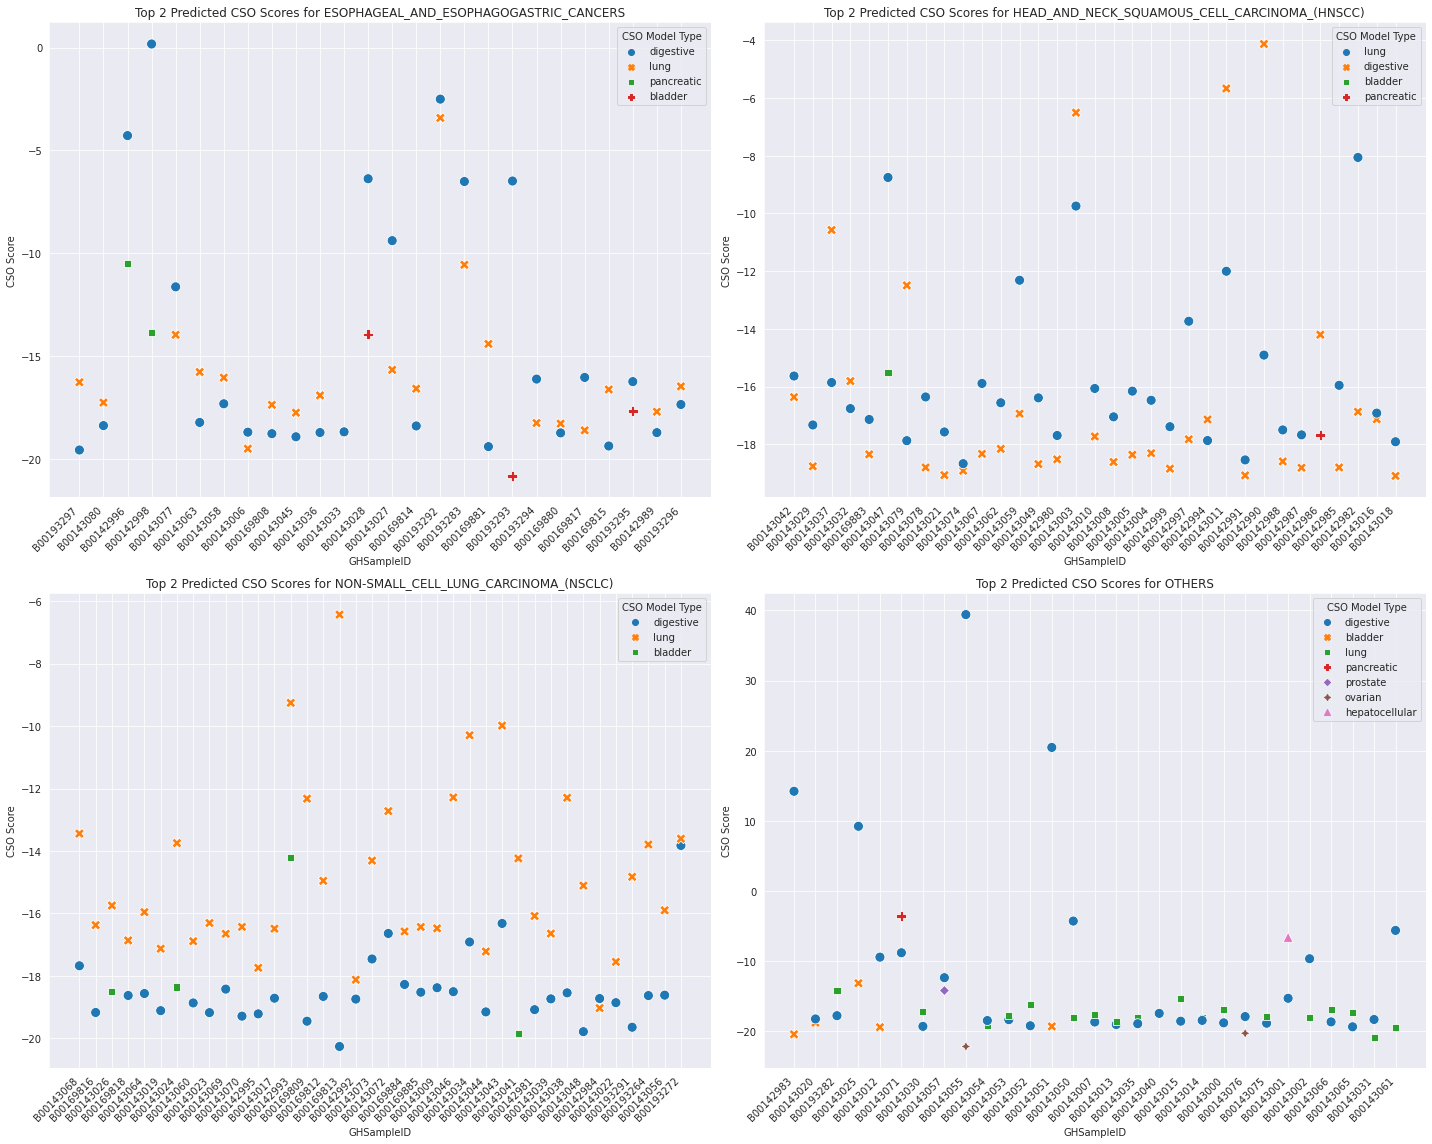

In [127]:
cancer_types = top_2_prd_df['CancerType'].unique()

n = len(cancer_types)
ncols = 2
nrows = (n + 1) // ncols  

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 8 * nrows)) 
axes = axes.flatten()  

for ax, cancer in zip(axes, cancer_types):
    df_subset = top_2_prd_df[top_2_prd_df['CancerType'] == cancer]
    
    # sns.scatterplot(data=df_subset, x='GHSampleID', y='cso_score', hue='cso_model_type', style='cso_model_type', s=100, ax=ax)
    sns.scatterplot(data=df_subset, x='GHSampleID', y='cso_score', hue='cso_prediction', style='cso_prediction', s=100, ax=ax)

    
    ax.set_title(f'Top 2 Predicted CSO Scores for {cancer}')
    ax.set_xlabel('GHSampleID')
    ax.set_ylabel('CSO Score')
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    ax.legend(title='CSO Model Type', loc='upper right')

plt.tight_layout()
plt.show()


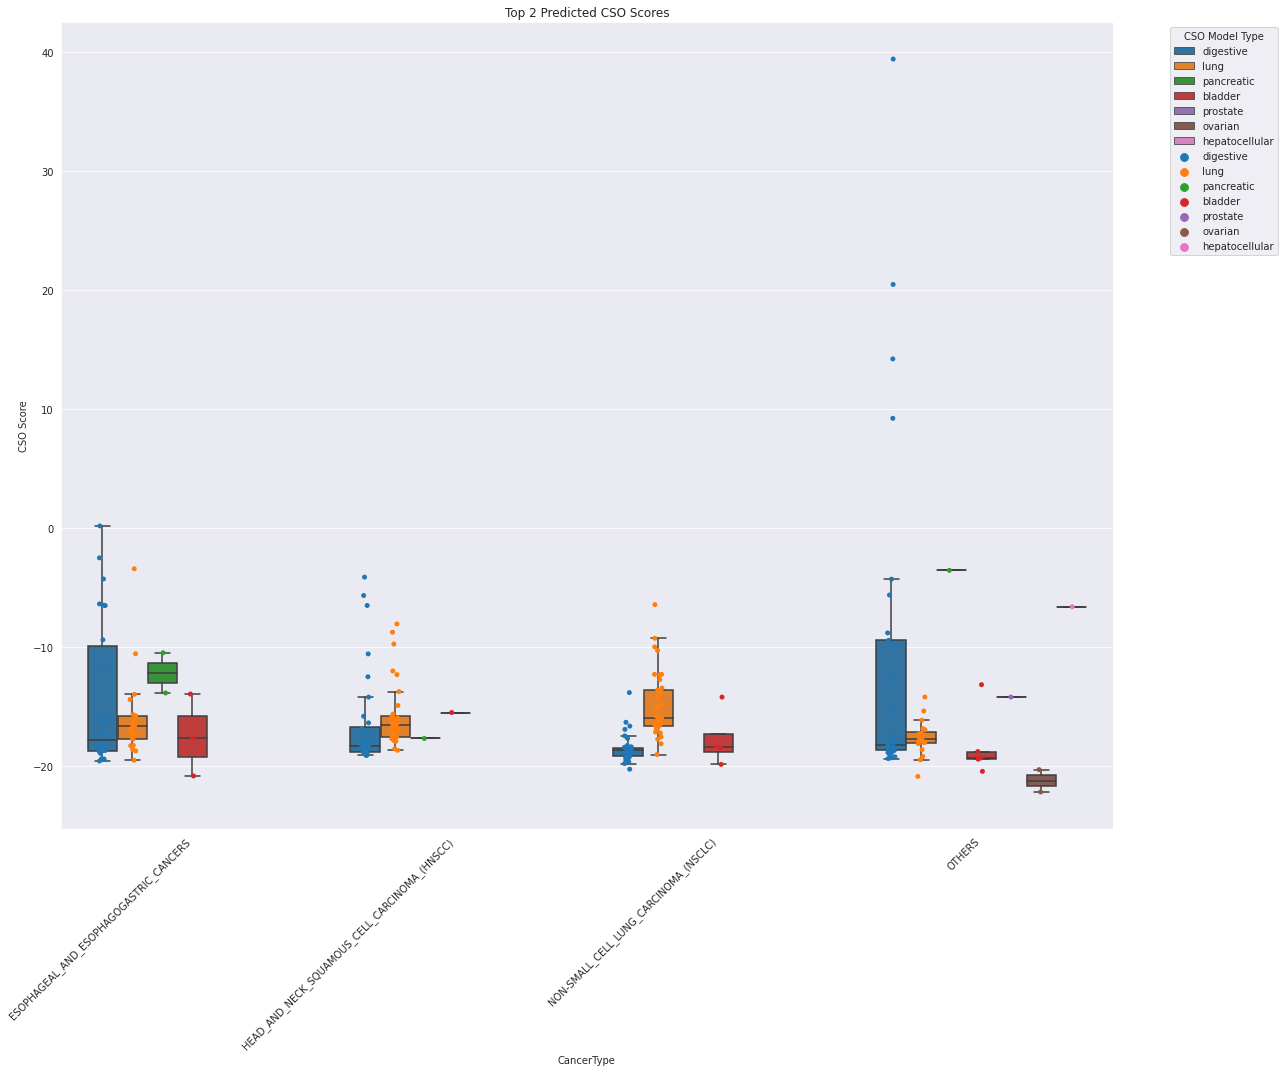

In [122]:
sns.set_style('darkgrid')

plt.figure(figsize=(18, 15))

sns.boxplot(data=top_2_prd_df, x='CancerType', y='cso_score', hue='cso_prediction', showfliers=False)

sns.stripplot(data=top_2_prd_df, x='CancerType', y='cso_score', hue='cso_prediction', jitter=True, size=5, dodge=True, linewidth=0.5, edgecolor='none')

plt.title('Top 2 Predicted CSO Scores')
plt.xlabel('CancerType')
plt.ylabel('CSO Score')

plt.xticks(rotation=45, ha='right')

plt.legend(title='CSO Model Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


## TFv2beta score generation (having bug to fix!!)

In [6]:
#set up python interpreter based
# This is for epiTFv2beta with plot
%env PYTHON=/ghdevhome/home/agross/enviroment/mambaforge/envs/work/bin/python
%env SCRIPT_DIR=/ghdevhome/home/agross/code/methylation_classifiers/scripts
%env SAMPLE_CMD=$SCRIPT_DIR/run_epiTF.py
%env BATCH_CMD=$SCRIPT_DIR/run_epiTF_batch.py

env: PYTHON=/ghdevhome/home/agross/enviroment/mambaforge/envs/work/bin/python
env: SCRIPT_DIR=/ghdevhome/home/agross/code/methylation_classifiers/scripts
env: SAMPLE_CMD=$SCRIPT_DIR/run_epiTF.py
env: BATCH_CMD=$SCRIPT_DIR/run_epiTF_batch.py


In [7]:
!echo $PYTHON
!echo $SCRIPT_DIR
!echo $SAMPLE_CMD
!echo $BATCH_CMD

/ghdevhome/home/agross/enviroment/mambaforge/envs/work/bin/python


/ghdevhome/home/agross/code/methylation_classifiers/scripts
$SCRIPT_DIR/run_epiTF.py
$SCRIPT_DIR/run_epiTF_batch.py


In [8]:
#generate epiTF output by TFv2beta with plot method local version
df_cytomx_1_new = df_cytomx_1.copy()

out_path = f"{work_dir}/TFv2_cytomx_ouput"

PYTHON = '/ghdevhome/home/agross/enviroment/mambaforge/envs/work/bin/python'
SCRIPT_DIR = '/ghdevhome/home/agross/code/methylation_classifiers/scripts/'

# Check if the output directory exists, if not, create it
if not os.path.exists(out_path):
    os.makedirs(out_path)

for index, row in df_cytomx_1.iterrows():
    #This is to deal the the cluster migration issue
    fc_dir = row["fc_dir_ori"]
    sample_id = row["GHSampleID"]
    sample_path = f"{fc_dir}/{sample_id}"
    mbd_path = f"{sample_path}/{sample_id}.mbd_hyper_molecules.tsv"

    try:
        # Run the script for each sample
        command = f"{PYTHON} {SCRIPT_DIR}run_epiTF.py {mbd_path} {sample_path} {out_path} {sample_id}"
        os.system(command)
    except FileNotFoundError:
        print(f"No file found for {sample_id}")
    except Exception as e:
        print(f"An error occurred with {sample_id}: {str(e)}")



In [9]:
#generate epiTF output by TFv2beta method slurm version

# Step 1: save the input csv file
df_cytomx_1_new = df_cytomx_1.copy()
df_cytomx_1_new.to_csv(f"{work_dir}/df_cytomx_1_new.csv", index=False)

# Step 2: edit the slurm script
# Step 2.1: define the out_path path; define the column # in the script for extracting "fc_dir" and "sample_id"; this is optional: | sed 's/\/ghess\//\/ghsfa\/projects\//'

# STEP 3: run the slurm script
os.system(f"sbatch {work_dir}/run_TFv2beta_pancanTF_accuracy.sh")

Submitted batch job 77677600


0